# Setting up pymupdf for image extraction

In [1]:
!pip install pymupdf
!pip install groq
!pip install beautifulsoup4
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 1.8 MB/s eta 0:00:00


In [2]:
import fitz
import io
import base64
import tempfile
from bs4 import BeautifulSoup
from IPython.display import Image, display

In [1]:
def convert_pdf_page_to_image(pdf_file_path, output_image_file_name, page_number, zoom=2):
    """
    Saves a specific page of a PDF to an image.

    Args:
    pdf_file_path (str): Path to the PDF file.
    page_number (int): Page number to convert to image (0-based index).
    zoom (float): Zoom factor for the image. Higher values mean better quality.
    output_image_file_name (str): Name of the output image file.
    """
    document = fitz.open(pdf_file_path)
    page = document.load_page(page_number)

    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat)

    pix.save(output_image_file_name)

    document.close()

In [5]:
pdf_file_path = "./Week_2/Day_4/Files/example.pdf"
output_image_file_path = "./Week_2/Day_4/Files/output_image.png"
page_number = 2  # First page
zoom = 2  # Zoom factor
convert_pdf_page_to_image(pdf_file_path, output_image_file_path, page_number, zoom)

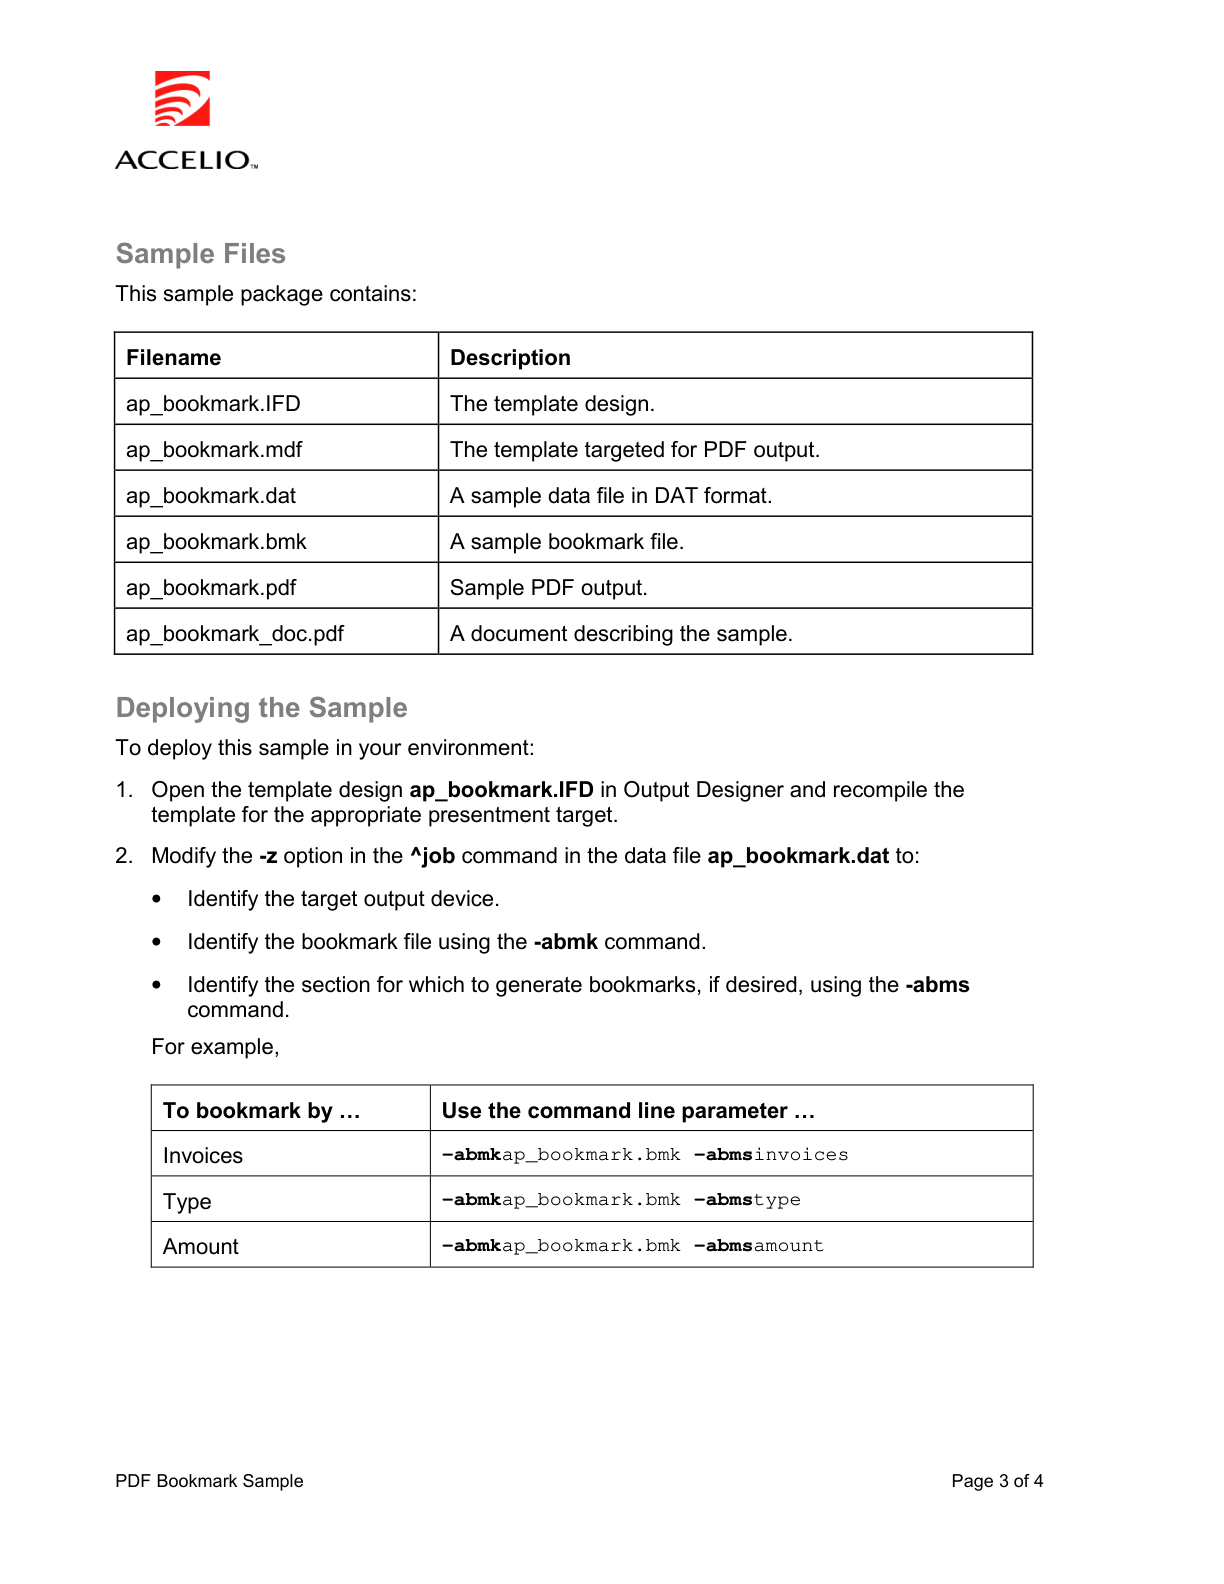

In [6]:
# Display the saved image
display(Image(filename=output_image_file_path))

In [8]:
# Function to encode the image in base64 format
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = output_image_file_path

# Getting the base64 string
base64_image = encode_image(image_path)

# Text extraction Using Groq

In [9]:
from groq import Groq


In [10]:
# API keys in google colab
from google.colab import userdata
groq_api_key = userdata.get('GROQ_API_KEY')
openai_api_key = userdata.get('OPENAI_API_KEY')

In [20]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Get the HUGGINGFACE_TOKEN
groq_api_key = os.getenv('GROQ_API_KEY')
openai_api_key = os.getenv('OPENAI_API_KEY')

In [ ]:
from groq import Groq
client = Groq(api_key=groq_api_key)
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",       # role system currently not supported by groq
            "content": [
                {"type": "text", "text": "Replicate the text within this image."},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}",
                    },
                },
            ],
        }
    ],
    model="llama-3.2-90b-vision-preview",
)

textInImage = chat_completion.choices[0].message.content

In [17]:
print(textInImage)

The image presents a sample PDF bookmark, featuring the Accelio logo in the top-left corner. The title "Sample Files" is prominently displayed at the top, followed by a list of sample files and their descriptions. Below this section, the "Deploying the Sample" instructions provide step-by-step guidance on how to deploy the sample.

The main content of the page is organized into three sections:

* **Deploying the Sample**: This section contains detailed instructions for deploying the sample.
* **To bookmark by ...**: This section features a table with two columns, titled "To bookmark by ..." and "Use the command line parameter ...". The table includes rows for "Invoices", "Type", and "Amount".
* **PDF Bookmark Sample**: This section displays the text "Page 3 of 4" at the bottom, indicating that it is part of a larger document.

Overall, the image effectively conveys information about the sample PDF bookmark and provides clear instructions for its deployment.


# Text extraction Using GPT-4o-mini

In [21]:
from openai import OpenAI

In [25]:
client = OpenAI(api_key=openai_api_key)
completion = client.chat.completions.create(
  model= "gpt-4o-mini",
  messages = [
            {
                "role": "system",
                "content": "Extract the text in this image"
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
  max_tokens= 4095
)

textInImage = completion.choices[0].message.content

In [26]:
print(textInImage)

Here's the extracted text from the image:

---

**Sample Files**  
This sample package contains:  

| Filename              | Description                                           |
|----------------------|-------------------------------------------------------|
| ap_bookmark.IFD      | The template design.                                  |
| ap_bookmark.mdf      | The template targeted for PDF output.                 |
| ap_bookmark.dat      | A sample data file in DAT format.                     |
| ap_bookmark.bmk      | A sample bookmark file.                               |
| ap_bookmark.pdf      | Sample PDF output.                                   |
| ap_bookmark_doc.pdf  | A document describing the sample.                      |

**Deploying the Sample**  
To deploy this sample in your environment:  

1. Open the template design **ap_bookmark.IFD** in Output Designer and recompile the template for the appropriate presentment target.  
2. Modify the **-z** option in the **@job